# Kiva Crowdfunding - Loans that change Lives

*Kiva is an international nonprofit organization with a mission to connect people through lending to alleviate poverty. Kiva.org is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world. Kiva lenders have provided over $1 billion dollars in loans to over 2 million people.*

## Project Goal

** Not all loans requested through KIVA are funded (about 3383 records in loans dataset that are not funded). In this project, we are trying to identify if a pattern exists among loans that are not getting funded. Our goal is to predict if a Loan is likely to get fully funded or not. As part of this analysis we determine the features that are of the highest importance to get a loan funded.**

In this notebook, we present three different perspective based on each of our analysis while achieving our common goal to predict if a loan is likely to get funded or not.

In [2]:
%matplotlib inline

# General libraries.
import re
import math
import numpy as np
import collections
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from mpl_toolkits.basemap import Basemap
color = sns.color_palette()
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, mixture # For clustering 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import feature_selection
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
import pydot
import graphviz

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

KeyError: 'PROJ_LIB'

## VERSION # 1

## 1a: Data Loading

In [ ]:
df_kiva_loans = pd.read_csv("kiva_loans.csv")
df_kiva_loans.head()

## 1b: EDA

In [ ]:
# Identify rows with no funding (Funding amount = 0)
df_nofund = df_kiva_loans[(df_kiva_loans['funded_amount']==0)]
df_nofund.shape


 **There are about 3383 rows with funded amount = 0**  

** MORE OBSERVATIONS **

- Philippines, Kenya and El Salvador are the top 3 countries featuring in Loans dataset based on the number of records  
- United States, Kenya and Pakistan are the countries top countries with loan amount not funded
- Agriculture, Food and Retail are the top 3 sectors based on Loan Amount
- Farming is the top activity based on Loan Amount, followed by General Store and Personal Housing Expenses
- There are more Female borrowers than male

NOTE: The EDA charts related to these observations have not been included since focus of this project is on the models. 

In [ ]:
countries_funded_amount = df_kiva_loans.groupby('country').mean()['funded_amount'].sort_values(ascending = False)
print("Top Countries with funded amount (Mean values)\n",countries_funded_amount.head(10))
data = [dict(
        type='choropleth',
        locations= countries_funded_amount.index,
        locationmode='country names',
        z=countries_funded_amount.values,
        text=countries_funded_amount.index,
        colorscale='Red',
        marker=dict(line=dict(width=0.7)),
        colorbar=dict(autotick=False, tickprefix='', title='Top Countries with funded_amount(Mean value)'),
)]
layout = dict(title = 'Countries based on Funded amount',
             geo = dict(
            showframe = False,
            #showcoastlines = False,
            projection = dict(
                type = 'Mercatorodes'
            )
        ),)
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False)

In [ ]:
# Determine Time Taken for Funding. It is Loan Posted Time - Funded Time

df_funded = df_kiva_loans[(df_kiva_loans['funded_amount']!=0)]
df_funded.dropna()
df_funded.shape

df_funded['funded_time'] = pd.to_datetime(df_funded['funded_time'])
df_funded['posted_time'] = pd.to_datetime(df_funded['posted_time'])    
time_to_fund = (df_funded.funded_time - df_funded.posted_time)
time_to_fund_in_days = (time_to_fund.astype('timedelta64[s]')/(3600 * 24))
df_funded = df_funded.assign(time_to_fund=time_to_fund)
df_funded = df_funded.assign(time_to_fund_in_days=time_to_fund_in_days)

funded_time = df_funded.groupby('country').mean()['time_to_fund_in_days'].sort_values(ascending = False)
print("Top Countries with max funded_time(Mean values)\n",funded_time.head(10))
data = [dict(
        type='choropleth',
        locations= funded_time.index,
        locationmode='country names',
        z=funded_time.values,
        text=funded_time.index,
        colorscale='Red',
        marker=dict(line=dict(width=0.7)),
        colorbar=dict(autotick=False, tickprefix='', title='Countries based on Funded Time'),
)]
layout = dict(title = 'Top Countries - Funded Time',
             geo = dict(
            showframe = False,
            #showcoastlines = False,
            projection = dict(
                type = 'Mercatorodes'
            )
        ),)
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False)

## 1c: Data Pre-processing

In [ ]:
use_col = ['funded_amount', 'loan_amount', 'sector', 'country', 'term_in_months', 'borrower_genders', 'repayment_interval']
df_loans = df_kiva_loans[use_col].copy()
df_loans.head()

In [ ]:
df_loans.isnull().sum()

In [ ]:
df_loans.dropna(inplace=True)

In [ ]:
df_loans.shape

In [ ]:
df_loans['percent_female'] = df_loans['borrower_genders'].apply(lambda x: np.mean(np.array(x.split(',')) == 'female'))
df_loans['applicants'] = df_loans['borrower_genders'].apply(lambda x: len(x.split(',')))
df_loans.drop('borrower_genders', axis=1, inplace=True)

In [ ]:
df_loans.head()

In [ ]:
df_loans['granted'] = 1*(df_loans['loan_amount'] == df_loans['funded_amount'])
df_loans.drop('funded_amount', axis=1, inplace=True)

In [ ]:
df_loans['granted'].value_counts()

** OBSERVATION: There are 47648 that are not fully funded. **

In [ ]:
df_loans = pd.concat((df_loans,pd.get_dummies(df_loans[['sector', 'country', 'repayment_interval']], drop_first=True)), axis=1)
df_loans.drop(['sector', 'country', 'repayment_interval'], axis=1, inplace=True)
df_loans.shape
df_loans.head()

df_loans1 = df_loans.copy()
features = df_loans.drop('granted', axis=1).columns

In [ ]:
X = df_loans.drop('granted', axis=1).values
y = df_loans['granted'].values
print(X.shape)
print(y.shape)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 1d: Model Building

### 1. Random Forest

In [ ]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
print("Score from Random Forest is %.2f%%" %(score*100))
y_pred = rfc.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

In [ ]:
print(classification_report(y_test, y_pred))

** OBSERVATION: Even though Random Forest model gave an accuracy score of 92.6%, it did bad on predicting class 0 (only 33% score on predicting loans that are not fully funded). There are close to 12K False Positives and 4K False Negatives. Also notice, the data between class 0 and 1 is uneven/imbalanced.**

### Feature Importance from Random Forest

In [ ]:
importances = pd.DataFrame({"Feature": features, 'Score': rfc.feature_importances_})
importances = importances.sort_values(by='Score', ascending=False).head(10)

In [ ]:
plt.figure(figsize=(8,8))
plt.barh(range(10), importances['Score'])
a = plt.yticks(range(10), importances['Feature'])

### 2. Decision Tree

In [ ]:
clf = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
                               max_depth=3, min_samples_leaf=5, min_samples_split=10)
clf.fit(X_train, y_train)
print ('Accuracy:', clf.score(X_test, y_test))

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=features,  
                      #class_names=y_test,  
                      filled=True, rounded=True,  
                      special_characters=True)


graph = graphviz.Source(dot_data)  
graph 

** OBSERVATION: Even though Decision Tree model gave an accuracy score of 92.8%, it did worse on predicting class 0 (0% score on predicting loans that are not fully funded). **

### 3. XGBoost

In [ ]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train, y_train)
y_pred = clf_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

print ('Accuracy:', clf_xgb.score(X_test, y_test))

y_pred = clf_xgb.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

In [ ]:
imp = pd.DataFrame({"Feature": features, "Score": clf_xgb.feature_importances_ })
imp = imp.sort_values(by = 'Score', ascending = False).head(10)
plt.figure(figsize= (8,8))
plt.barh(range(10),imp["Score"])
a = plt.yticks(range(10), importances["Feature"])

** OBSERVATION: XGBoost scored only 8% on Class 0 (loans that are not fully funded) while Class 1 (fully funded) was predicted at 96%. **

### 4. Logistic Regression - UNADJUSTED

In [ ]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print("Score from Logisitic Regression is %.2f%%" %(score*100))

print(classification_report(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

### 5. Logistic Regression with Balanced Class weight and Grid Search Best Parameters

In [ ]:
lgr = LogisticRegression(penalty = 'l2', C=0.5)
lgr.fit(X_train,y_train)
 
cval = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 20.0, 30.0, 50.0, 100.0]}
grid = GridSearchCV(estimator=lgr, param_grid=cval, cv=5,scoring='f1_weighted' )
grid.fit(X_train, y_train)
print('The best value for C', grid.best_params_)
print('The best score',grid.best_score_)

In [ ]:
lgr = LogisticRegression(class_weight="balanced", penalty = 'l2', C=0.5)
lgr.fit(X_train,y_train)
predict = lgr.predict(X_test)
score1 = lgr.score(X_test, y_test)
print("Score from Logisitic Regression with balanced class is %.2f%%" %(score1*100))

print(classification_report(y_test, predict))

confusion_matrix(y_test, predict)
tn, fp, fn, tp = confusion_matrix(y_test, predict, labels=[0,1]).ravel()
print ('Confusion Matrix after adding Class_weight')
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

### 6. Logistic Regression after Downsampling

In [ ]:
# Separate majority and minority classes
from sklearn.utils import resample
df_majority = df_loans1[df_loans1.granted == 1]
df_minority = df_loans1[df_loans1.granted == 0]
df_minority.shape

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=47648,     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.granted.value_counts()

In [ ]:
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    df_downsampled.drop('granted', axis=1).values, df_downsampled['granted'].values, 
                 test_size=0.33, random_state=42)

In [ ]:
# Separate input features (X) and target variable (y)

# Train model
clf_2 = LogisticRegression(class_weight="balanced", penalty = 'l2', C=0.5).fit(X_train_balanced, y_train_balanced)
 
# Predict 
y_pred = clf_2.predict(X_test_balanced)

score1 = lgr.score(X_test_balanced, y_test_balanced)
print("Score from Logisitic Regression with balanced class is %.2f%%" %(score1*100))

# accuracy
print(classification_report(y_test_balanced, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test_balanced, y_pred, labels=[0,1]).ravel()
print ('Confusion Matrix after adding Class_weight')
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

** OBSERVATION: After downsampling, Logistic Regression gave more balanced results with class 0(non funded) score increase from 7% to 75%. However, Class 1 scoring decreased due to the decrease in sample data. Overall, downsampling gave the best results for Logistic Regression **

### 7. Revisit Random Forest with balanced data

In [ ]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train_balanced, y_train_balanced)
y_pred = rfc.predict(X_test_balanced)

score1 = rfc.score(X_test_balanced, y_test_balanced)
print("Score from Logisitic Regression with balanced class is %.2f%%" %(score1*100))

print(classification_report(y_test_balanced, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test_balanced, y_pred, labels=[0,1]).ravel()
print ('Confusion Matrix after adding Class_weight')
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

** OBSERVATION: After downsampling, Random Forest gave more balanced results with class 0(non funded) score increase from 32% to 80%. However, Class 1 scoring decreased due to the decrease in sample data. Overall, Random Forest after downsampling did better than ANY other model above.**

### Feature Importance based on SelectKBest

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# feature extraction
test = SelectKBest(score_func=chi2, k=10)
fit = test.fit(X_train, y_train)
# summarize scores
np.set_printoptions(precision=3)

sorted_features = features[fit.scores_.argsort()]
for i, x in enumerate(features[fit.scores_.argsort()].tolist()[::-1][:10]):
    print(x)

### 8. Unsupervised Learning

In [ ]:
pca = PCA(n_components=10)
train_data_comp = pca.fit_transform(X_train)

test_data_comp = pca.transform(X_test)

km = KMeans(n_clusters=2, init='k-means++')
clstrs = km.fit(train_data_comp)

plt.scatter(train_data_comp[:,0], train_data_comp[:,1], c=clstrs.labels_)
plt.plot(clstrs.cluster_centers_[:,0], clstrs.cluster_centers_[:,1], 'ro')  
plt.show() 


In [ ]:
clf_pos = GMM(n_components=2, covariance_type='full')
clf_pos.fit(train_data_comp[y_train == 1, :])

clf_neg = GMM(n_components=2, covariance_type='full')
clf_neg.fit(train_data_comp[y_train == 0, :])

prob_pos = clf_pos.score_samples(test_data_comp)
prob_neg = clf_neg.score_samples(test_data_comp)
    
test_class1 = (prob_pos> prob_neg).astype(int)

print ("GMM Accuracy = %.2f%% percent" %(np.mean(test_class1 == y_test)*100))
print(classification_report(y_test, test_class1))

In [ ]:
pca = PCA(n_components=10)
train_data_comp = pca.fit_transform(X_train_balanced)
test_data_comp = pca.transform(X_test_balanced)

clf_pos = GMM(n_components=2, covariance_type='full')
clf_pos.fit(train_data_comp[y_train_balanced == 1, :])

clf_neg = GMM(n_components=2, covariance_type='full')
clf_neg.fit(train_data_comp[y_train_balanced == 0, :])

prob_pos = clf_pos.score_samples(test_data_comp)
prob_neg = clf_neg.score_samples(test_data_comp)
    
test_class1 = (prob_pos> prob_neg).astype(int)

print ("GMM Accuracy = %.2f%% percent" %(np.mean(test_class1 == y_test_balanced)*100))
print(classification_report(y_test_balanced, test_class1))

** OBSERVATION: GMM did a lot better after downsampling (Class 0 score increased from 23% to 72%). However, this is still lower than Supervised Learning prediction.**

## Summary

| Model                                 | Overall Accuracy | 0 score | 1 score | False Positive | False Negative |
|---------------------------------------|------------------|---------|---------|----------------|----------------|
| Random Forest                         |       92.6%      |   32%   |   96%   |      11941     |      4334      |
| Decision Tree                         |       92.8%      |    0%   |   96%   |                |                |
| XG Boost                              |       93.1%      |    8%   |   96%   |      15124     |       675      |
| Logistic Reg - Unadj                  |       92.8%      |    7%   |   96%   |      15245     |       663      |
| Logistic Reg after Parameter tuning   |       72.6%      |   28%   |   83%   |      3820      |      56560     |
| Logistic Reg after Downsampling       |      74.69%      |   75%   |   74%   |      3674      |      4422      |
| Random Forest after Downsampling      |      79.97%      |   81%   |   79%   |      2599      |      3745      |
| Unsupervised -   GMM                  |       65.4%      |   23%   |   78%   |                |                |
| Unsupervised - GMM after Downsampling |      70.47%      |   72%   |   69%   |                |                |

## Version 2

Most EDA is not shown below but is contained in separate notebook.

In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [7]:
kiva_loans = pd.read_csv('kiva_loans.csv')

In [9]:
kiva_loans.head(3)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01


In [10]:
lf = (kiva_loans.funded_amount - kiva_loans.loan_amount)
kiva_loans['funded'] = lf

In [11]:
#Starting binarizing process; changing any value of 0.0 to 1
#which indicates load was fully funded

mask = kiva_loans.funded == 0.0
column_name = 'funded'
kiva_loans.loc[mask, column_name] = 1

In [12]:
#Changing any values that are not 1 to 0 which indicates loan not
#fully funded

alt = kiva_loans.funded != 1.0
column_name = 'funded'
kiva_loans.loc[alt, column_name] = 0

In [13]:
kiva_loans = kiva_loans.dropna(axis=0, subset=['borrower_genders'])

In [14]:
#group genders and apply dummy variables

kiva_loans['gender']=[elem if elem in ['female','male'] else 'group' for elem in kiva_loans['borrower_genders']]
dummy = pd.get_dummies(kiva_loans['gender'])
kiva_loans = pd.concat([kiva_loans,dummy], axis =1)

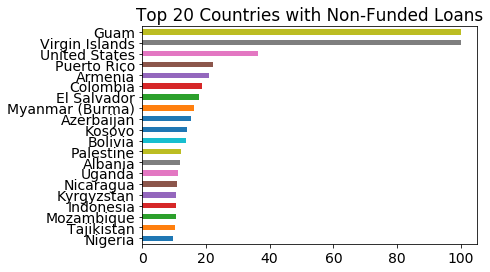

In [15]:
#Plotting percentage of non-funded loans by country; Guam and the Virgin
#Islands have almost a 100% rate of non-funded loans

A = (kiva_loans[kiva_loans['funded']==0]['country'].value_counts()/kiva_loans['country'].value_counts() * 100).sort_values(ascending=False)
A[0:20].sort_values().plot(kind='barh', title='Top 20 Countries with Non-Funded Loans')

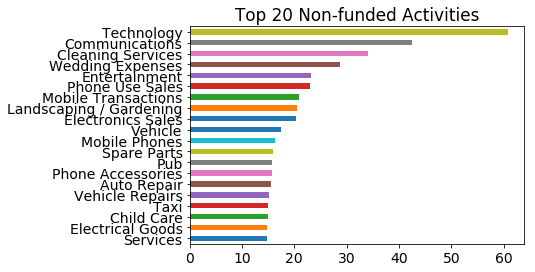

In [17]:
#plotting above data and only showing top 20 activities not funded

B = (kiva_loans[kiva_loans['funded']==0]['activity'].value_counts()/kiva_loans['activity'].value_counts() * 100).sort_values(ascending = False)
B[0:20].sort_values().plot(kind='barh', title='Top 20 Non-funded Activities')

In [18]:
#Create two dataframes: one for funded loans and one for non-funded loans

df_funded = kiva_loans[kiva_loans['funded'] == 1]
df_notfunded = kiva_loans[kiva_loans['funded'] == 0]

In [19]:
#Create funded dataframe with size of 50000 to be comparable to non-funded
#dataframe size; cap df size at 50,000 and choose every 3rd value

df_funded_s = df_funded.sample(n=50000, random_state=3)
df_funded_s.shape

(50000, 25)

In [20]:
#Merge funded sample size dataframe with non-funded dataframe for 
#prediction down below

df_final_s = pd.concat([df_funded_s, df_notfunded], ignore_index=True)
df_final_s.shape

(97648, 25)

Based on extensive EDA, the following variables appeared to influence
whether or not a loan was funded:

- Country
- Lender Count
- Repayment Interval
- Loan Term (in months)
- Activity
- Amount of Loan Request
- Borrower Gender
- Repayment Time

Initially I tried to dummy the relevant features and run Recursive Feature Elimination and reduce 850+ independent variables to top 50. This was too much for RFE. I also tried to run SMOTE on 850+ 'dummied' variables but SMOTE kept timing out.

In [21]:
#first prediction uses 'funded_amount' as independent variable; for this
#first pass, I am not going to make dummy vars with the funded amount

set1 = df_final_s[['funded_amount', 'funded']]
set1.head()

,funded_amount,funded
0,1450.0,1.0
1,850.0,1.0
2,925.0,1.0
3,450.0,1.0
4,350.0,1.0


In [22]:
X = set1.iloc[:, :-1]
y = set1.iloc[:, -1]
print(X.shape)
print(y.shape)

(97648, 1)
(97648,)


In [23]:
#split data into train and test; allocate 30% to test data

#at .52, the accuracy is not very good

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set:{:.2f}'.
      format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set:0.52


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[7808 6509]
 [7619 7359]]


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.55      0.53     14317
         1.0       0.53      0.49      0.51     14978

   micro avg       0.52      0.52      0.52     29295
   macro avg       0.52      0.52      0.52     29295
weighted avg       0.52      0.52      0.52     29295



Now create dummies with funded_amount var and see if this improves accuracy.

In [28]:
set1_dum = pd.get_dummies(data=set1, columns=['funded_amount'])
set1_dum.head(1)

,funded,funded_amount_0.0,funded_amount_5.0,funded_amount_10.0,funded_amount_15.0,funded_amount_20.0,funded_amount_25.0,funded_amount_30.0,funded_amount_35.0,funded_amount_40.0,...,funded_amount_16350.0,funded_amount_17050.0,funded_amount_18050.0,funded_amount_18325.0,funded_amount_20000.0,funded_amount_22500.0,funded_amount_30000.0,funded_amount_40000.0,funded_amount_46125.0,funded_amount_50000.0
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
#this moves 'funded' column to last column in dataframe

cols = set1_dum.columns.tolist()
column_to_move = 'funded'
new_position = 498
cols.insert(new_position, cols.pop(cols.index(column_to_move)))
set1_final = set1_dum[cols]
set1_final.head()

,funded_amount_0.0,funded_amount_5.0,funded_amount_10.0,funded_amount_15.0,funded_amount_20.0,funded_amount_25.0,funded_amount_30.0,funded_amount_35.0,funded_amount_40.0,funded_amount_45.0,...,funded_amount_17050.0,funded_amount_18050.0,funded_amount_18325.0,funded_amount_20000.0,funded_amount_22500.0,funded_amount_30000.0,funded_amount_40000.0,funded_amount_46125.0,funded_amount_50000.0,funded
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [30]:
X1 = set1_final.iloc[:, :-1]
y1 = set1_final.iloc[:, -1]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=0)
#logreg = LogisticRegression()
logreg.fit(X1_train, y1_train)

y_pred = logreg.predict(X1_test)
print('Accuracy of logistic regression classifier on test set:{:.2f}'.
      format(logreg.score(X1_test, y1_test)))

print()

print(classification_report(y1_test, y_pred))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set:0.60

              precision    recall  f1-score   support

         0.0       0.61      0.52      0.56     14317
         1.0       0.60      0.68      0.64     14978

   micro avg       0.60      0.60      0.60     29295
   macro avg       0.60      0.60      0.60     29295
weighted avg       0.60      0.60      0.60     29295



#### By binarizing the independent variable, accuracy improved from .52 to .60

#### All models run using Logistic Regression.


| Independent Variable                  | Overall Accuracy | 0 score | 1 score | 
|---------------------------------------|------------------|---------|---------|
| Loan Amount (not 'dummied')           |       51.8%      |   32%   |   96%   |  
| Loan Amount (dummy)                   |       60.3%      |    0%   |   96%   | 
| Activity (dummy)                      |       60.6%      |    8%   |   96%   | 
| Gender (dummy)                        |       63.6%      |    7%   |   96%   |  
| Country (dummy)                       |       66.7%      |   28%   |   83%   | 
| Loan Term in Months (dummy)           |       67.9%      |   75%   |   74%   |  
| Repayment Interval (dummy)            |       62.6%      |   81%   |   79%   |     
| Sector (dummy)                        |       55.8%      |   23%   |   78%   |

  
  
| Loan Term, Country                                   |      70.5%       |   72%   |   69%   |  
| Loan Term, Country, Gender                           |      73.7%       |   72%   |   69%   |
| Loan Term, Country, Gender, Repayment                |      73.3%       |   72%   |   69%   |
| Loan Term, Country, Gender, Repayment, Activity      |      76.4%       |   72%   |   69%   |





#### Combinations (all dummied)

  
| Loan Term, Country                                   |      70.5%       |   72%   |   69%   |  
| Loan Term, Country, Gender                           |      73.7%       |   72%   |   69%   |
| Loan Term, Country, Gender, Repayment                |      73.3%       |   72%   |   69%   |
| Loan Term, Country, Gender, Repayment, Activity      |      76.4%       |   72%   |   69%   |

## Version 3